# Binary classification on MNIST (Quantum model)

In [4]:
import pennylane as qml
from pennylane import numpy as np
import torch # to use PennyLane TorchLayer class to perform circuit operations and optimisations with PyTorch backend
from matplotlib import pyplot as plt

from utils.tools import get_dataset, visualise_data

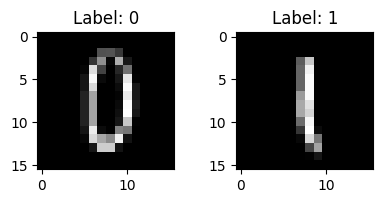

In [24]:
digits = [0,1]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

In [6]:
X_train = np.reshape(x_train, (len(x_train), n_px, n_px))
X_test = np.reshape(x_test, (len(x_test), n_px, n_px))
Y_train = y_train
Y_test = y_test

print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (1000, 16, 16)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (1000,)
dType : uint8
pyType: <class 'numpy.ndarray'>


In [7]:
#### Hyperparameters ####
input_dim = n_px * n_px # 16 X 16 pixels
num_classes = len(digits)
num_layers = 32
num_qubits = 8
num_reup = 3

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(101)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cpu


In [8]:
import time
t = time.time()
#### Hyperparameters ####
learning_rate = 0.1
epochs = 8
batch_size = 20

# we use a subset of the training and validation data for this tutorial to speed up the training
n_train = 400
n_test = 100

feats_train = torch.from_numpy(X_train[:n_train]).reshape(n_train, -1).to(device)
feats_test = torch.from_numpy(X_test[:n_test]).reshape(n_test, -1).to(device)
labels_train = torch.from_numpy(Y_train[:n_train]).to(device)
labels_test = torch.from_numpy(Y_test[:n_test]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:100]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:100])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:100], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=epochs)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs, max_ep=epochs)

elapsed = time.time() - t
print(f"\nTime elapsed: {elapsed} s.")

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 0.6859950 | Cost (val): 0.6852965 | Approx Acc train: 0.5400000 | Acc val: 0.5800000
Epoch 1/4 | Approx Cost (train): 0.3892801 | Cost (val): 0.3918715 | Approx Acc train: 0.9900000 | Acc val: 1.0000000
Epoch 2/4 | Approx Cost (train): 0.2386826 | Cost (val): 0.2469231 | Approx Acc train: 1.0000000 | Acc val: 0.9900000
Epoch 3/4 | Approx Cost (train): 0.1935178 | Cost (val): 0.2074538 | Approx Acc train: 1.0000000 | Acc val: 0.9900000
Epoch 4/4 | Approx Cost (train): 0.1894974 | Cost (val): 0.2082464 | Approx Acc train: 1.0000000 | Acc val: 0.9800000
Epoch 5/4 | Approx Cost (train): 0.2041641 | Cost (val): 0.2089902 | Approx Acc train: 0.9900000 | Acc val: 0.9900000
Epoch 6/4 | Approx Cost (train): 0.1785167 | Cost (val): 0.1954627 | Approx Acc train: 1.0000000 | Acc val: 0.9900000
Epoch 7/4 | Approx Cost (train): 0.1782396 | Cost (val): 0.1893306 | Approx Acc train: 1.00

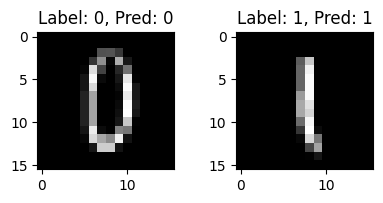

In [26]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(num_classes, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualise_data(digits, x_vis, y_vis, benign_class_output)

## PDG attack

In [22]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

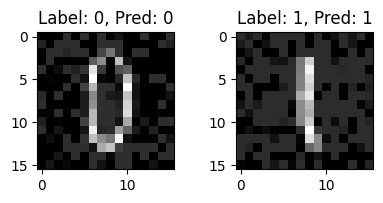

In [27]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px), y_vis, adversarial_class_output)